### Analyze label transfer quality based on newly mapped healthy data (=Meyer_2021 dataset)

Here we analyze quality of label transfer from the HLCA core to the carefully pre-annotated Meyer_2021 healthy lung dataset.

Load modules:

In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import sys
import os

sys.path.append("../../scripts/")
import reference_based_harmonizing
import matplotlib.pyplot as plt
import seaborn as sns
import sankey

For pretty code formatting:

In [2]:
%load_ext lab_black

set paths:

In [3]:
path_ct_df = "../../supporting_files/celltype_structure_and_colors/manual_anns_and_leveled_anns_ordered.csv"
path_adata = "../../data/HLCA_extended/HLCA_core_plus_single_study/HLCA_meyer_2021_adata_full_tcnorm_log1p.h5ad"
path_ct_harmonizing = "../../supporting_files/metadata_harmonization/HLCA_cell_type_reference_mapping_20221007.csv"
dir_figures = "../../results/figures/"
path_meyer_label_transfer_results = (
    "../../results/HLCA_ext_label_transfer/meyer_label_transfer_detailed.csv"
)

load data and tables:

In [4]:
adata = sc.read_h5ad(path_adata)

In [5]:
ct_df = pd.read_csv(path_ct_df, index_col=0)

store the obs just for the meyer data in a separate dataframe, for easy of calculations below:

In [6]:
adata_meyer_obs = adata.obs.loc[adata.obs.study == "Meyer_2021", :].copy()

remove prefixes from original annotations and transfered annotations:

In [7]:
# for original annotations
orig_ann_mapping = dict()
for orig_ann in adata_meyer_obs.original_ann_level_5.unique():
    split_ann = orig_ann.split("_")
    if split_ann[0] in ["1", "2", "3", "4", "5"]:
        ann_no_prefix = "_".join(split_ann[1:])
    else:
        ann_no_prefix = orig_ann
    orig_ann_mapping[orig_ann] = ann_no_prefix

adata_meyer_obs[
    "original_ann_level_5_no_prefix"
] = adata_meyer_obs.original_ann_level_5.map(orig_ann_mapping)
# and transfered annotations:
transf_ann_mapping = dict()
for transf_ann in adata_meyer_obs.transf_ann_level_5_label.unique():
    split_ann = transf_ann.split("_")
    if split_ann[0] in ["1", "2", "3", "4", "5"]:
        ann_no_prefix = "_".join(split_ann[1:])
    else:
        ann_no_prefix = transf_ann
    transf_ann_mapping[transf_ann] = ann_no_prefix

adata_meyer_obs[
    "transf_ann_level_5_label_no_prefix"
] = adata_meyer_obs.transf_ann_level_5_label.map(transf_ann_mapping)

we need our cell type reference to know the relations between possible finer annotations than our manual annotations (we did put them in the reference):

In [8]:
harmonizing_df = reference_based_harmonizing.load_harmonizing_table(path_ct_harmonizing)
consensus_df = reference_based_harmonizing.create_consensus_table(harmonizing_df)

## Label matching between query and reference

For each dataset, we need to clarify how the original annotations from the dataset match with the labels that we transferred from the atlas to the new data. (In that way we can check when the transfer was correct and when it wasn't). This is a bit more complicated for the Meyer dataset, which has very detailed annotations in some cases. So for that dataset, we take three steps:  
1. Get those annotations that match 1-to-1. 
2. Get those annotations that are coarser in the query than in the reference. We will classify them as correct when a matching finer label is transferred, but have to make sure to use the coarser (=query) label when making figures, of the label transfer, so as not to suggest better performance of our label transfer than is the case. 
3. Get those annotations that are finer in the query than in the reference. We will classify them as correct when the correct coarser label is transferred, but have to make sure to use the coarser (=reference) label when making figures, for reasons outlined in (2).
4. Match remaining annotations manually (these will mostly be new cell types, absent in the reference, or in some case mismatches (e.g. matching with parts of multiple "clades").


In [9]:
# We need to store correct matching of the reference manual annotations
# to the meyer data annotations, so that we can determine when label
# transfer was corect.
# inititate a dictionary in which we will store the correct matching,
# so that we can later categorize label transfers into correct and incorrect
original_to_transferred = dict()
# initiate list of annotations that do not have an exact one-to-one
# match
no_direct_translation = list()
# inititate list of meyer annotations that have neither a one-to-one match,
# nor a match with a coarsified versions of the atlas' annotations
no_direct_translation_and_no_match_with_finer_anns = list()
# initiate a litst of meyer annotations that are neither a finer, nor
# a coarser version of our manual annotations, but have no match that
# can be found automatically
meyer_matchless = list()
# initiate a dict to track which annotations are the same in query and
# reference
same_in_ref_and_query = dict()
# initiate a dict to track which annotations are coarser in the reference
coarser_in_ref = dict()
# initiate a dict to track which annotations are finer in the reference
finer_in_ref = dict()
# STEP 1
# Now start searching mathces. First, search for one-to-one matches
for ann in adata_meyer_obs.original_ann_level_5_no_prefix.unique():
    if ann in ct_df.Level_5.index:
        original_to_transferred[ann] = [ann]
        same_in_ref_and_query[ann] = ann
    else:
        no_direct_translation.append(ann)
# STEP 2
# if our manual annotation is more detailed than the meyer annotation:
# then we should be able to find the label in our ct_df df
# (the hierarchical version of our manual annotation) at a coarser level
# than the finest available:
for ann in no_direct_translation:
    translation_found = False
    for level in range(1, 5):
        if ann in ct_df[f"Level_{level}"].values:
            matching_rows = np.where(ann == ct_df[f"Level_{level}"].values)[0]
            matching_labels = ct_df.index[matching_rows].tolist()
            #                 print(f"{ann} match: {matching_labels}")
            original_to_transferred[ann] = matching_labels
            finer_in_ref[ann] = matching_labels
            if level < 3:
                print(
                    f"For {ann}, we only found a level {level} annotation. Consider setting to unknown."
                )
            translation_found = True
    if not translation_found:
        no_direct_translation_and_no_match_with_finer_anns.append(ann)
# STEP 3
# if meyer annotation is more detailed than our manual annotation,
# consider a correct coarser annotation correct, but store these
# annotations also as "coarsified":
for ann in no_direct_translation_and_no_match_with_finer_anns:
    match_found = False
    # extract all rows from our reference that contain the meyer ann
    ct_ref_rows = np.where(
        [
            ann in consensus_df.iloc[row, :].values
            for row in range(consensus_df.shape[0])
        ]
    )[0]
    # if there are any, continue:
    if len(ct_ref_rows) > 0:
        # if there's more than one row, something is wrong (i.e. multiple
        # manual annotations match this meyer annotation)
        if len(ct_ref_rows) > 1:
            print(
                f"WARNING: more than 1 matching row found for {ann}. Check this. Skipping the annotation for now."
            )
        # otherwise
        else:
            ct_level_anns = consensus_df.iloc[ct_ref_rows, :]
            for level in range(1, 5):
                if ct_level_anns[f"level_{level}"].values in ct_df.index.tolist():
                    matching_coarse_ann = ct_level_anns.loc[
                        :, f"level_{level}"
                    ].values.tolist()
                    #                         print(
                    #                             f"Success! Meyer ann: {ann}, Level: {level}, matching lower level: {matching_coarse_ann}"
                    #                         )

                    coarser_in_ref[ann] = matching_coarse_ann[0]
                    original_to_transferred[ann] = matching_coarse_ann
                    match_found = True

    if not match_found:
        #             print(f"WARNING: No matching rows found for {ann}")
        meyer_matchless.append(ann)
# STEP 4
# manually assign matches where posssible to matchless annotations
# (set translation to "New" if the cell type does not match any cell type in
# the reference atals):
manual_translations = {
    "Erythrocytes": ["New"],
    "Basal proliferating": ["Basal resting", "Suprabasal"],  # unclear case
    "Schwann myelinating": ["New"],
    "Gamma-delta T cells": ["New"],
    "Megakaryocytes": ["New"],
    "NKT cells": ["New"],
    "Chondrocytes": ["New"],
    "Regulatory T cells": ["New"],
    "ILCs": ["New"],
    "SMG basal A": ["New"],
    "MAIT cells": ["New"],
    "Mph proliferating": [
        "Alveolar Mph proliferating",
        "Interstitial Mph perivascular",
        "Monocyte-derived Mph",
        "Alveolar macrophages",
    ],  # NOT SURE WHAT TO DO WITH THIS ONE due to resolution mismatch, now taking all macrophage labels from reference, and calling them "macrophages" in the figures
    "Schwann nonmyelinating": ["New"],
    "Nerve-associated fibroblasts": ["New"],
    "Macrophages SPP1 high": [
        "Alveolar Mph proliferating",
        "Interstitial Mph perivascular",
        "Monocyte-derived Mph",
        "Alveolar macrophages",
    ],  # NOT SURE WHAT TO DO WITH THIS ONE due to resolution mismatch/absence in healthy reference, now taking all macrophage labels from reference, and calling them "macrophages" in the figures
}
# store those anotations that had to be coarsified in our "coarser_in_ref"
# dictionary, for figure creation later (we can only say these were correctly
# labeled at the lower level.)
coarser_in_ref["Basal proliferating"] = "Basal"
coarser_in_ref["Mph proliferating"] = "Macrophages"
coarser_in_ref["Macrophages SPP1 high"] = "Macrophages"
# # update original_to_transferred dict:
original_to_transferred.update(manual_translations)
# FINAL CHECK:
for ann in adata_meyer_obs.original_ann_level_5_no_prefix.unique():
    if ann not in original_to_transferred.keys():
        print(f"WARNING! No translation found for {ann}")

For Lymphatic EC, we only found a level 2 annotation. Consider setting to unknown.


/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/ipykernel_launcher.py:63: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Check if you're mapping to existing finest level cts:

In [10]:
cts_translated_to = [ct for cts in original_to_transferred.values() for ct in cts]
cts_incorrect = list()
for ct in cts_translated_to:
    if (
        ct not in ct_df.index and ct not in cts_incorrect and ct != "New"
    ):  # ct_df.values
        cts_incorrect.append(ct)
if len(cts_incorrect) > 0:
    print("You translated to a non-existing ct:", cts_incorrect)

and mapping from meyer cts:

In [11]:
non_meyer_cts = [
    ct
    for ct in original_to_transferred.keys()
    if ct not in adata_meyer_obs.original_ann_level_5_no_prefix.unique()
]
if len(non_meyer_cts) > 0:
    print("You are mapping non-existing Meyer cts!", non_meyer_cts)

Now add a column to our transfer res and (further below) adata, that has cell type annotations to use for the label transfer figures. For those annotations that were coarser in the reference than in the query, we display the coarse annotation in the figures (so as to not suggest the annotation was correct at the finer level, e.g. macrophages proliferating or SPP1 high macrophages.)

In [12]:
query_to_figure_label = dict()
query_to_figure_label.update(same_in_ref_and_query)
query_to_figure_label.update(coarser_in_ref)
for coarse_label in finer_in_ref.keys():
    query_to_figure_label[coarse_label] = coarse_label
for label, transl_list in manual_translations.items():
    transl = transl_list[0]
    if label not in query_to_figure_label.keys():
        if transl == "New":
            query_to_figure_label[label] = label
        else:
            query_to_figure_label[label] = transl

In [13]:
adata_meyer_obs["original_ann_for_label_tr_fig"] = pd.Categorical(
    adata_meyer_obs.original_ann_level_5_no_prefix.map(query_to_figure_label).astype(
        str
    )
)

calculate evaluation (correct or incorrect label transfer):

In [14]:
adata_meyer_obs["label_tr_evaluation"] = "Incorrect"
for ct, correct_labels in original_to_transferred.items():
    cells_to_evaluate_correct = adata_meyer_obs.loc[
        (adata_meyer_obs.original_ann_level_5_no_prefix == ct)
        & (adata_meyer_obs.transf_ann_level_5_label_no_prefix.isin(correct_labels)),
        :,
    ].index
    adata_meyer_obs.loc[cells_to_evaluate_correct, "label_tr_evaluation"] = "Correct"

print mapping used for label transfer evaluation:

In [15]:
original_to_transferred

{'AT1': ['AT1'],
 'Plasma cells': ['Plasma cells'],
 'Non-classical monocytes': ['Non-classical monocytes'],
 'Interstitial Mph perivascular': ['Interstitial Mph perivascular'],
 'AT2': ['AT2'],
 'Alveolar macrophages': ['Alveolar macrophages'],
 'Adventitial fibroblasts': ['Adventitial fibroblasts'],
 'Classical monocytes': ['Classical monocytes'],
 'AT2 proliferating': ['AT2 proliferating'],
 'EC aerocyte capillary': ['EC aerocyte capillary'],
 'Plasmacytoid DCs': ['Plasmacytoid DCs'],
 'DC2': ['DC2'],
 'Mast cells': ['Mast cells'],
 'SMG mucous': ['SMG mucous'],
 'DC1': ['DC1'],
 'EC general capillary': ['EC general capillary'],
 'EC venous systemic': ['EC venous systemic'],
 'Myofibroblasts': ['Myofibroblasts'],
 'EC venous pulmonary': ['EC venous pulmonary'],
 'Alveolar fibroblasts': ['Alveolar fibroblasts'],
 'Pericytes': ['Pericytes'],
 'Peribronchial fibroblasts': ['Peribronchial fibroblasts'],
 'Alveolar Mph MT-positive': ['Alveolar Mph MT-positive'],
 'Monocyte-derived Mph': 

add thresholded columns, to set cells with uncertainty > threshold to "Unknown":

In [16]:
unc_thresh = 0.3
adata_meyer_obs[
    "label_tr_evaluation_thresholded"
] = adata_meyer_obs.label_tr_evaluation.tolist()
adata_meyer_obs[
    "transf_ann_level_5_label_no_prefix_thresholded"
] = adata_meyer_obs.transf_ann_level_5_label_no_prefix.tolist()
adata_meyer_obs.loc[
    adata_meyer_obs.transf_ann_level_5_uncert > unc_thresh,
    "label_tr_evaluation_thresholded",
] = "Unknown"
adata_meyer_obs.loc[
    adata_meyer_obs.transf_ann_level_5_uncert > unc_thresh,
    "transf_ann_level_5_label_no_prefix_thresholded",
] = "Unknown"

In [17]:
adata_meyer_obs.label_tr_evaluation.value_counts()

Correct      98926
Incorrect    30414
Name: label_tr_evaluation, dtype: int64

In [18]:
print(unc_thresh)
print("Evaluation counts:")
print(adata_meyer_obs.label_tr_evaluation_thresholded.value_counts())
print("\nEvaluation percentages:")
print(
    round(
        adata_meyer_obs.label_tr_evaluation_thresholded.value_counts()
        / adata_meyer_obs.shape[0]
        * 100,
        0,
    )
)

0.3
Evaluation counts:
Correct      87820
Unknown      23627
Incorrect    17893
Name: label_tr_evaluation_thresholded, dtype: int64

Evaluation percentages:
Correct      68.0
Unknown      18.0
Incorrect    14.0
Name: label_tr_evaluation_thresholded, dtype: float64


add results to adata:

In [19]:
for obs in [
    "original_ann_level_5_no_prefix",
    "transf_ann_level_5_label_no_prefix",
    "original_ann_for_label_tr_fig",
    "label_tr_evaluation",
    "label_tr_evaluation_thresholded",
    "transf_ann_level_5_label_no_prefix_thresholded",
]:
    adata.obs[obs] = np.nan
    adata.obs.loc[adata_meyer_obs.index, obs] = adata_meyer_obs[obs]

add data source info to adata:

In [20]:
adata.obs["HLCA_or_query"] = "HLCA core"
adata.obs.loc[
    adata.obs.study == "Meyer_2021", "HLCA_or_query"
] = "New data (healthy lung)"

## plot label transfer results:

In [21]:
FIGURES = dict()

In [22]:
sc.set_figure_params(dpi=140)

get celltype plotting order, and colors (for ref) for reference and query labels:

In [23]:
# for ref
cts_core = ct_df.index.tolist()
ct2col_ref = {ct: col for ct, col in zip(ct_df.index, ct_df.colors)}
ct2col_ref["Unknown"] = "#959595"
ct2col_ref["nan"] = "#959595"
# for query:
cts_q = adata_meyer_obs.original_ann_for_label_tr_fig.unique()
cts_q_rank = pd.DataFrame(index=cts_q, columns=["rank"])
cts_q_rank.index.name = "celltype"
for ct in cts_q:
    corresponding_rows = np.where(
        [ct in ct_df.loc[ref_ct_row, :].values for ref_ct_row in ct_df.index]
    )[0]
    if len(corresponding_rows) == 0:
        cts_q_rank.loc[
            ct, "rank"
        ] = 1000  # artificially high so that new cts will be sorted to the end
    else:
        cts_q_rank.loc[ct, "rank"] = corresponding_rows[0]
ct_df_q = cts_q_rank.sort_values(by=["rank", "celltype"]).index.tolist()

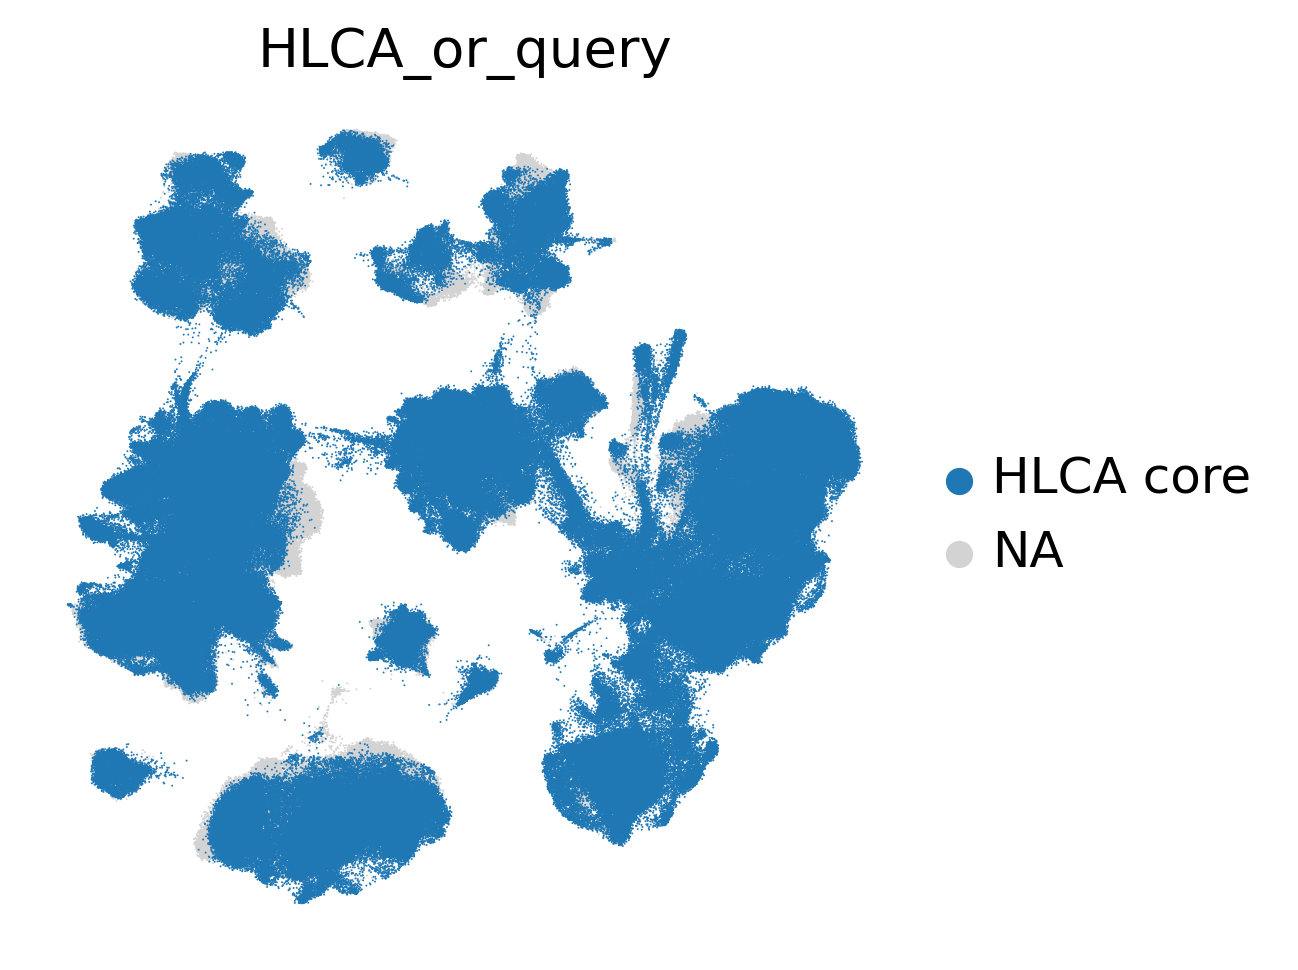

In [24]:
colors_ref_vs_q = {"HLCA core": "tab:blue", "New data (healthy lung)": "tab:cyan"}
FIGURES[f"ED12a_meyer_umap_ref_vs_q_ref"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="HLCA core",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q,
)

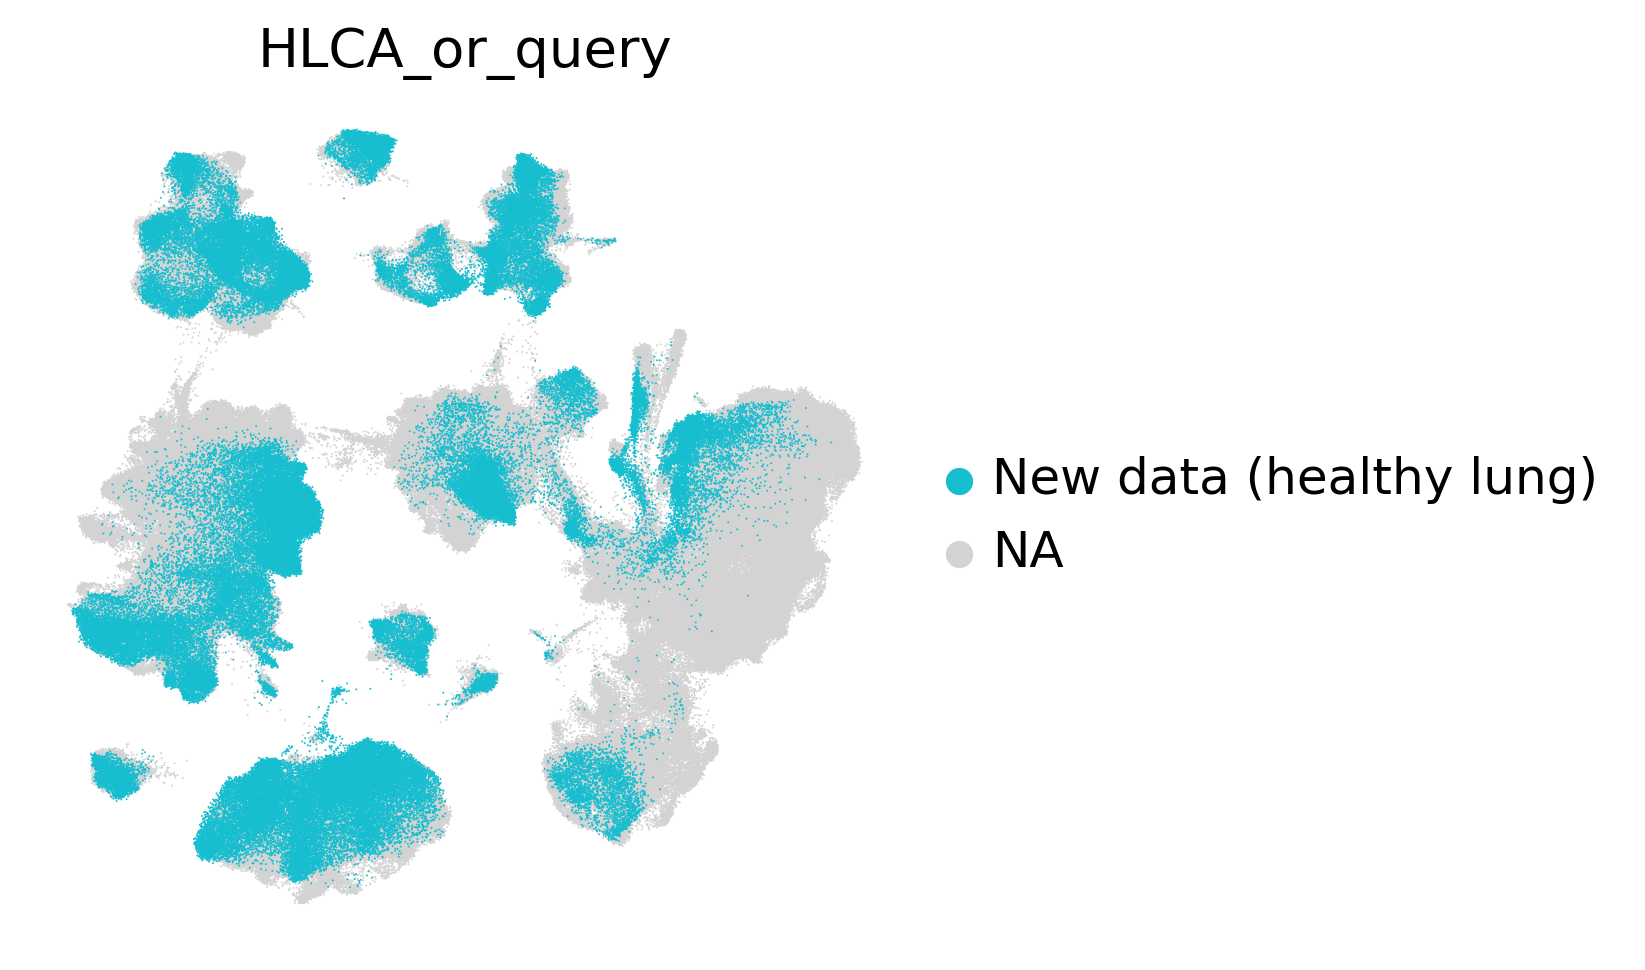

In [25]:
FIGURES["ED12b_meyer_umap_ref_vs_q_query"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="New data (healthy lung)",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    palette=colors_ref_vs_q,
)

as per reviewers request, a Seurat splitby version of the two umaps above:

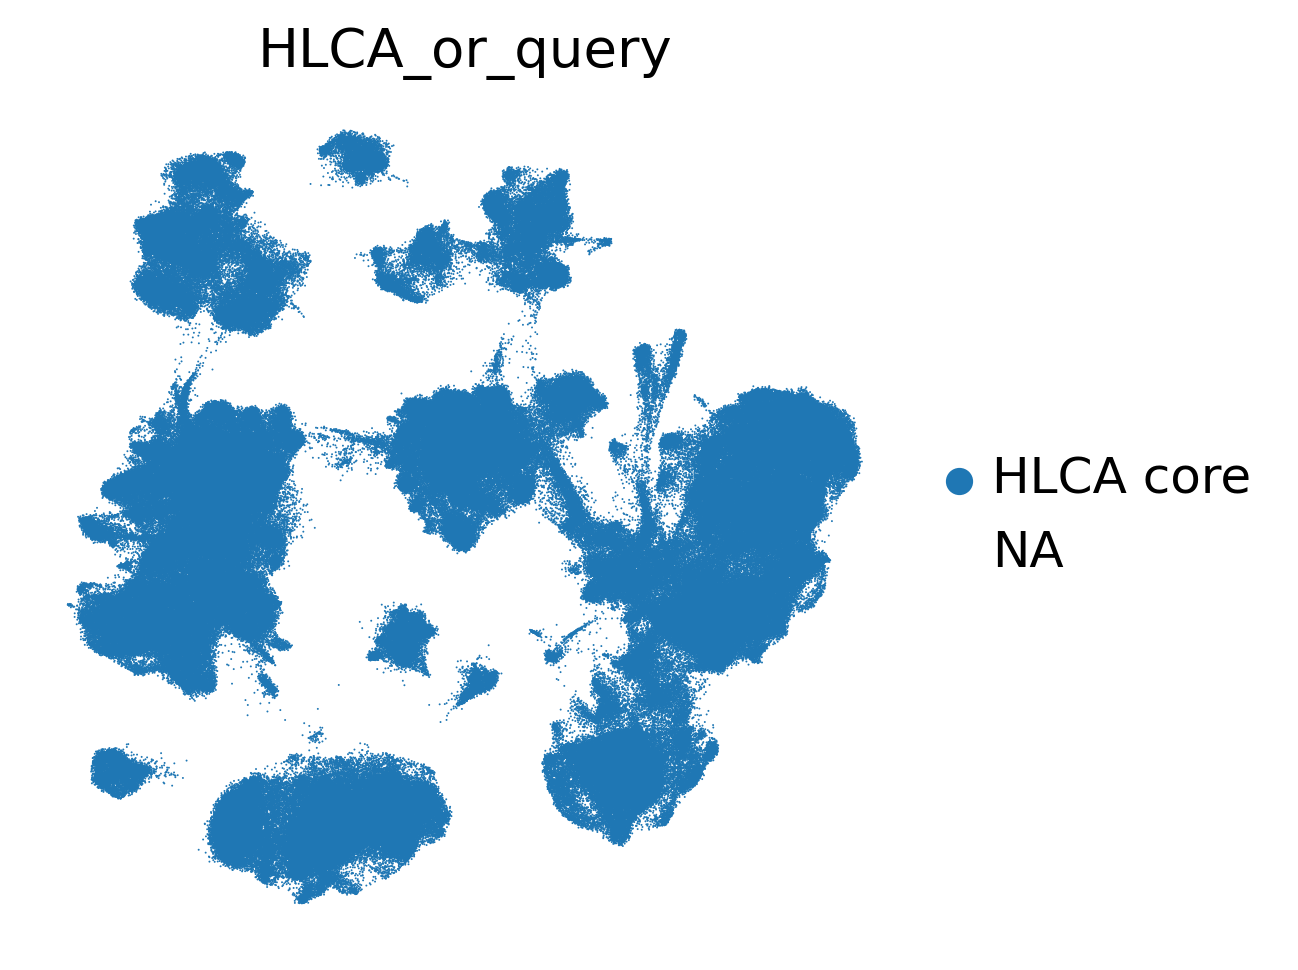

In [26]:
FIGURES["REVIEWER_meyer_umap_ref_vs_q_ref_splitby"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="HLCA core",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    na_color="white",
    palette=colors_ref_vs_q,
)

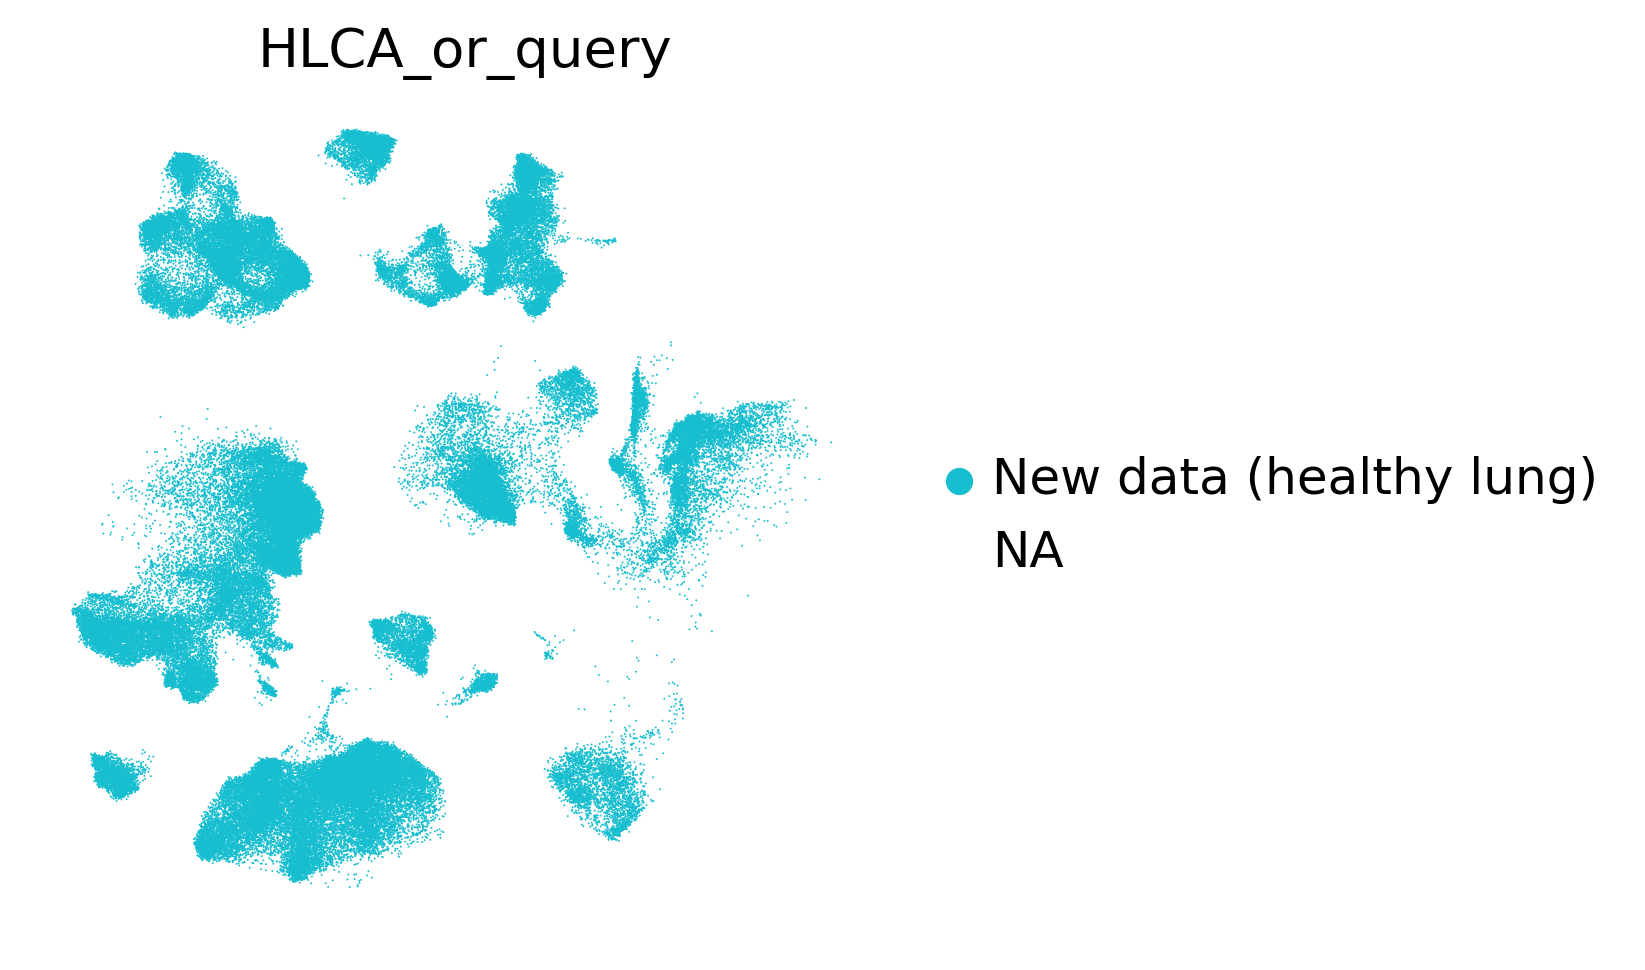

In [27]:
FIGURES["REVIEWER_meyer_umap_ref_vs_q_query_splitby"] = sc.pl.umap(
    adata,
    color="HLCA_or_query",
    groups="New data (healthy lung)",
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=True,
    na_color="white",
    palette=colors_ref_vs_q,
)

randomize adata order for plotting:

In [28]:
index_list = adata.obs.index.tolist()
np.random.shuffle(index_list)
adata = adata[index_list, :].copy()

Order manual ann in the same way as rest of the paper:

In [29]:
adata.obs["manual_ann"] = adata.obs["manual_ann"].cat.reorder_categories(
    new_categories=ct_df.index
)

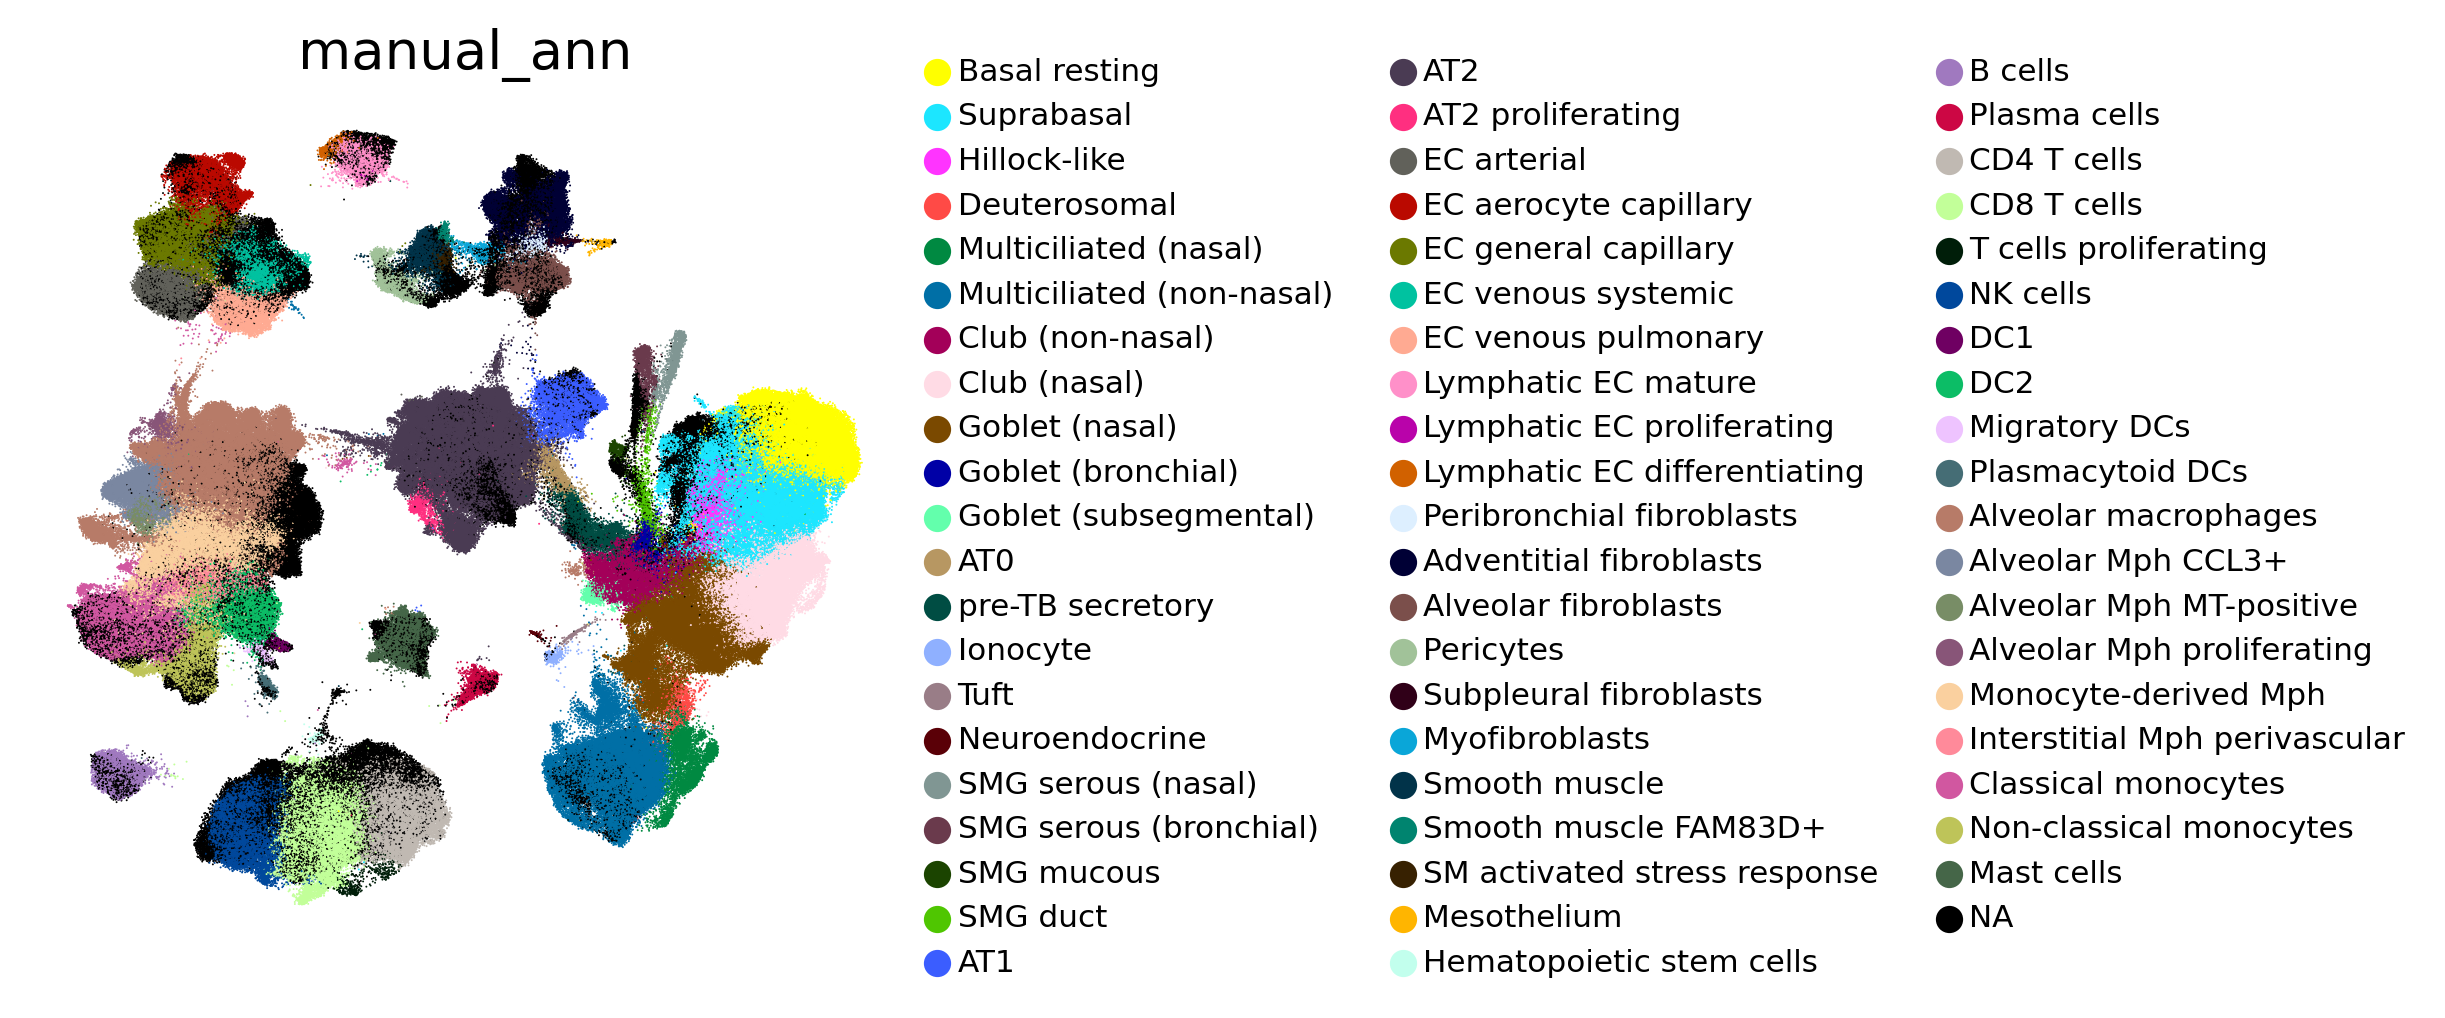

In [30]:
FIGURES["ED12c_meyer_umap_core_anns"] = sc.pl.umap(
    adata,
    color=["manual_ann"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    na_color="black",
    palette=ct2col_ref,
    legend_fontsize=8,
)

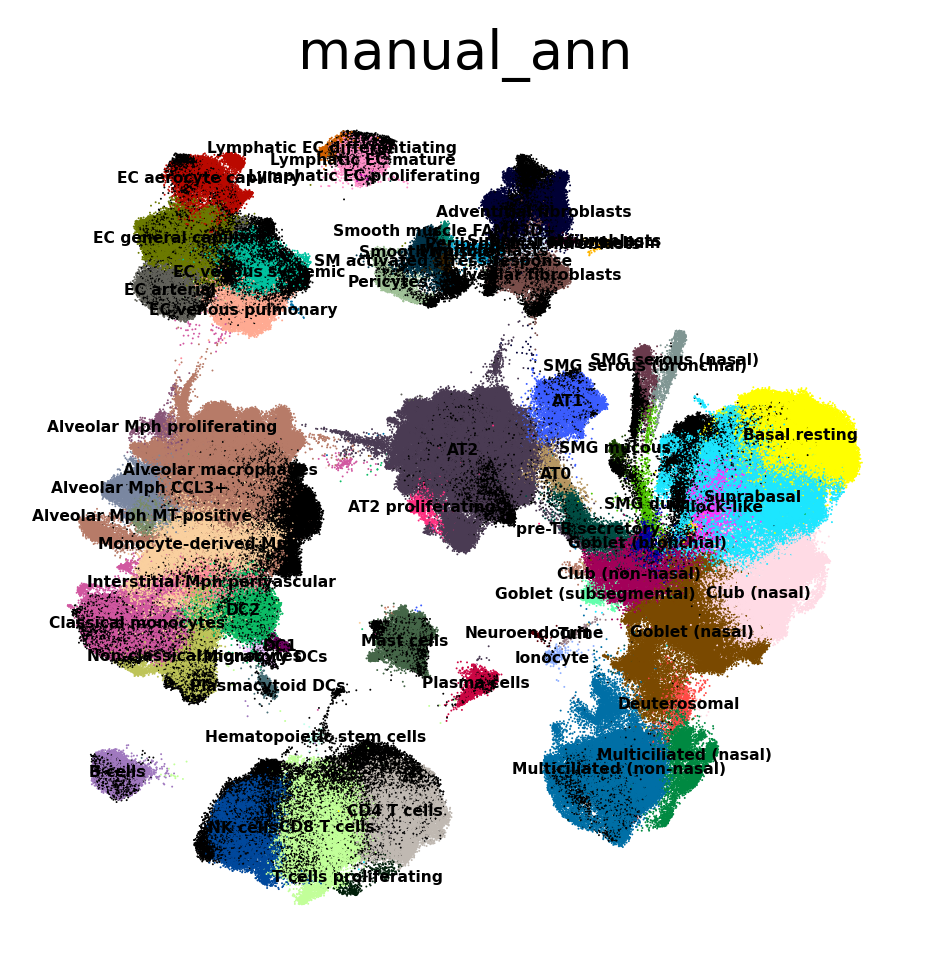

In [31]:
FIGURES["ED12c_meyer_umap_core_anns_labels_on_top"] = sc.pl.umap(
    adata,
    color=["manual_ann"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    na_color="black",
    palette=ct2col_ref,
    legend_fontsize=4,
    legend_loc="on data",
)

create a sorted embedding, such that cells from HLCA come first and rest comes after (but is mixed). This will ensure that HLCA cells are plotted on the bottom

In [32]:
HLCA_cells = adata.obs.index[adata.obs.HLCA_or_query == "HLCA core"].tolist()
query_cells = adata.obs.index[adata.obs.HLCA_or_query != "HLCA core"].tolist()

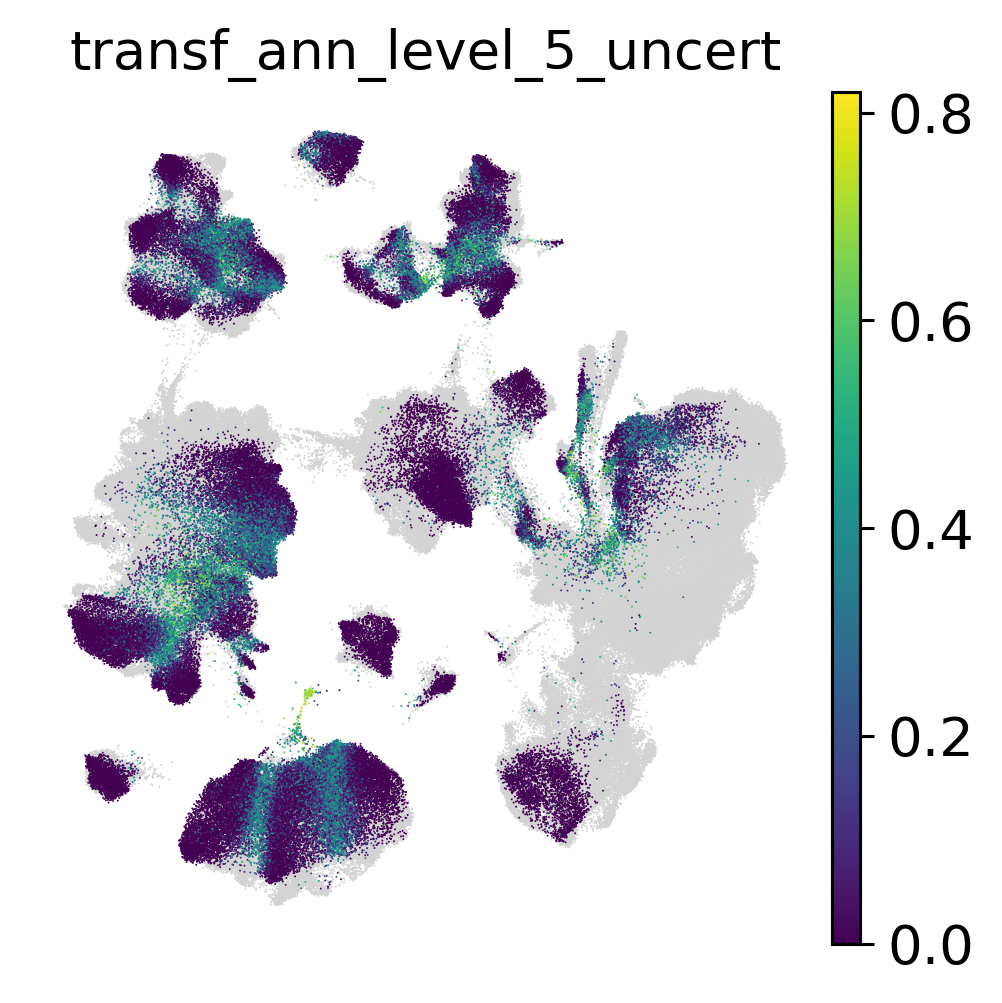

In [33]:
FIGURES[f"5a_meyer_umap_uncert"] = sc.pl.umap(
    adata[HLCA_cells + query_cells, :],
    color=["transf_ann_level_5_uncert"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
)

/home/icb/lisa.sikkema/miniconda3/envs/HLCA_basic/lib/python3.7/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


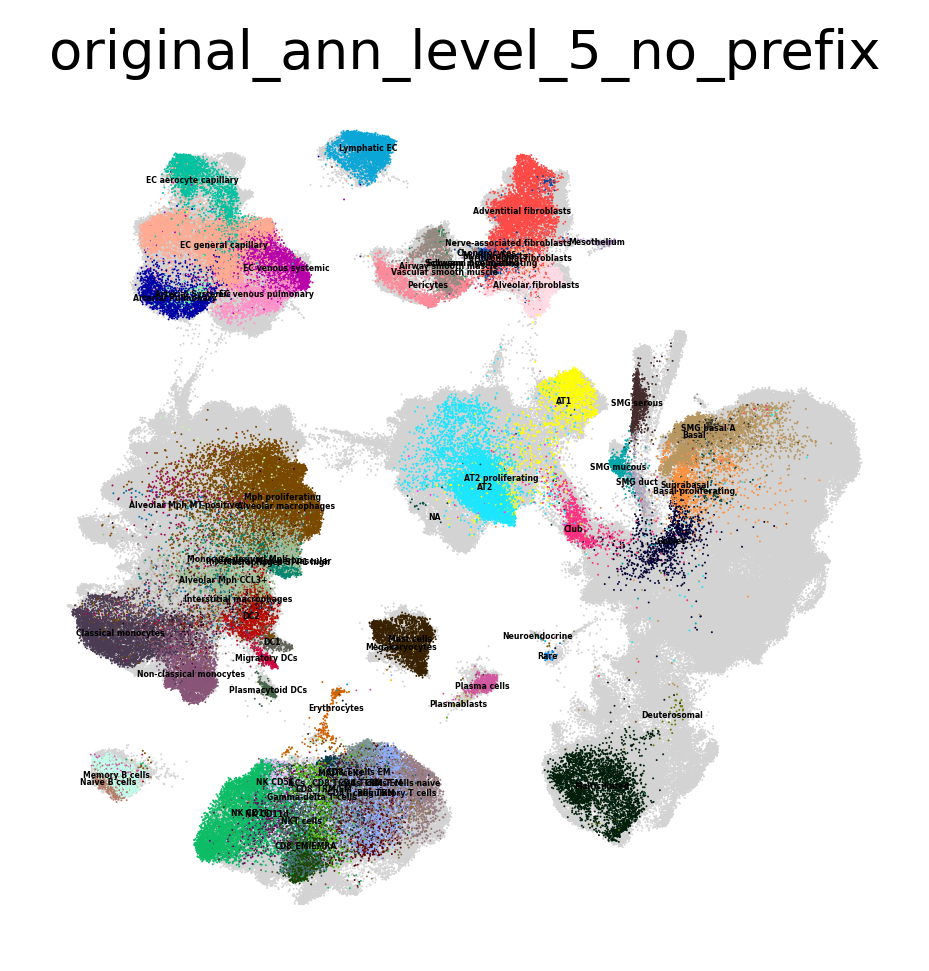

In [34]:
FIGURES[f"ED5a_support_meyer_umap_query_orig_labels"] = sc.pl.umap(
    adata[HLCA_cells + query_cells, :],
    color=["original_ann_level_5_no_prefix"],
    s=1,
    frameon=False,
    return_fig=True,
    sort_order=False,
    legend_loc="on data",
    legend_fontsize=2,
)

order figure cell type labels based on hierarchical reference:

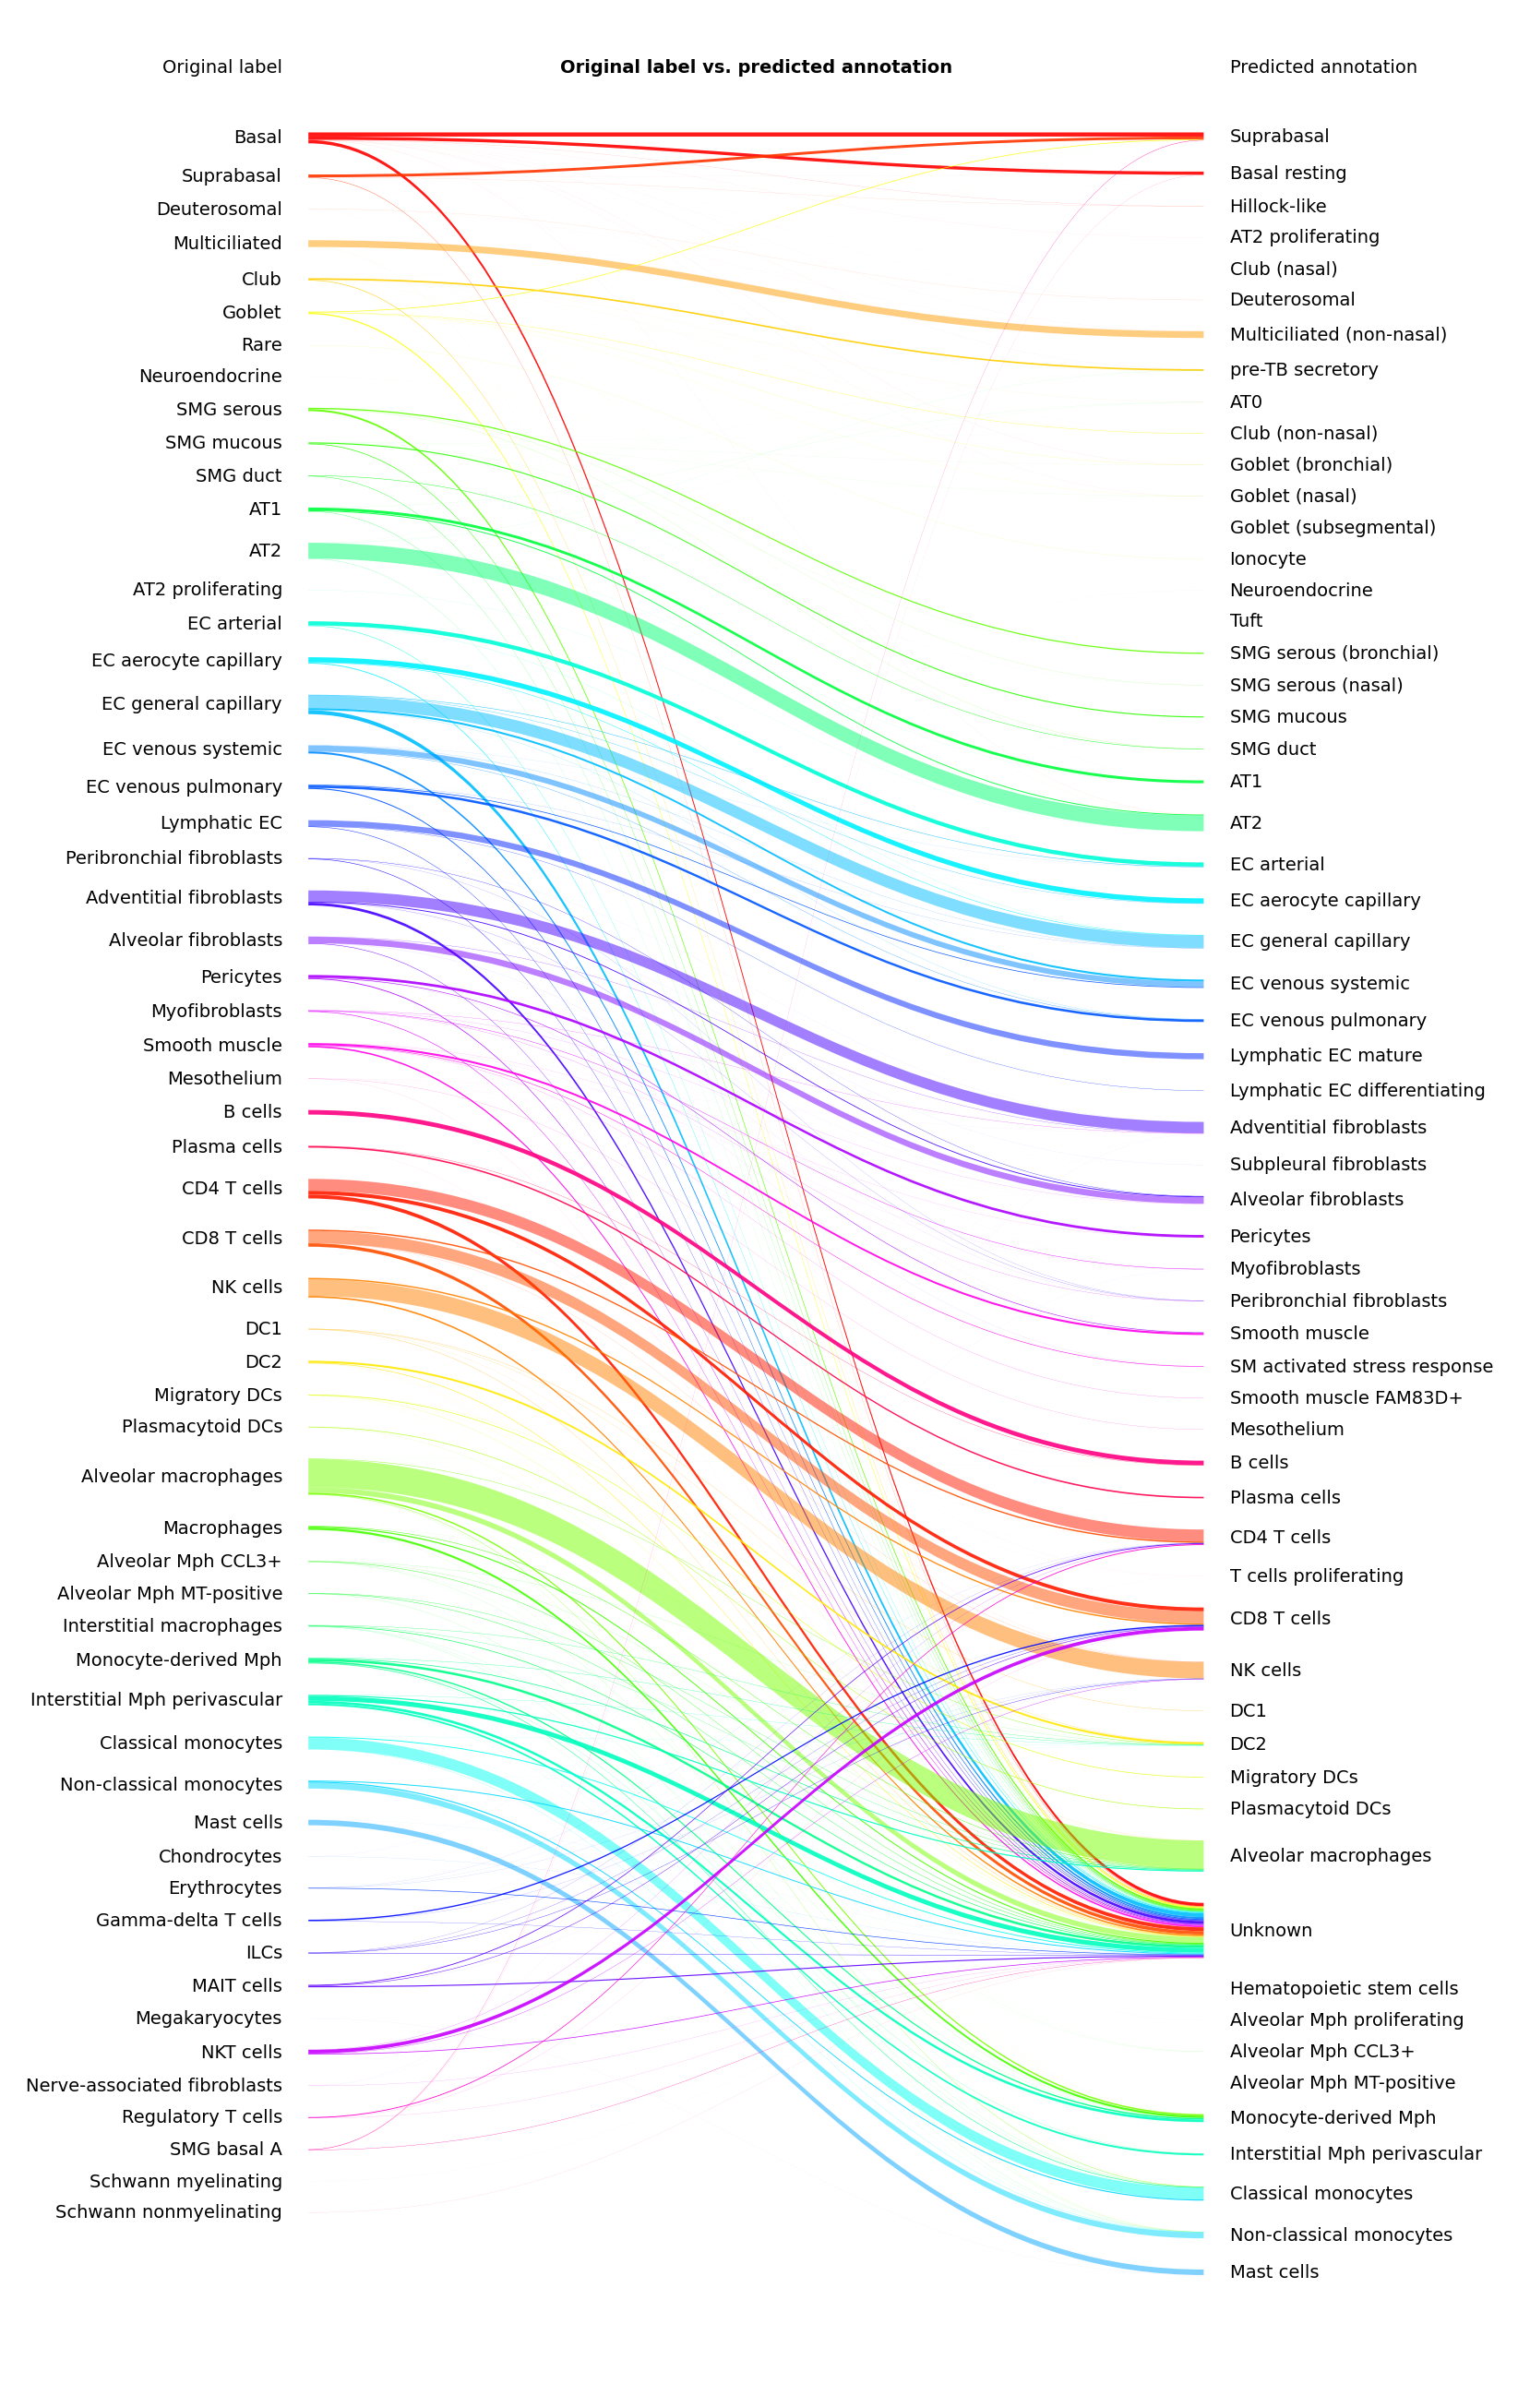

In [35]:
fig, ax = plt.subplots(figsize=(7, 12))
sankey.sankey(
    x=adata_meyer_obs.original_ann_for_label_tr_fig,
    y=adata_meyer_obs.transf_ann_level_5_label_no_prefix_thresholded,
    title="Original label vs. predicted annotation",
    title_left="Original label",
    title_right="Predicted annotation",
    ax=ax,
    fontsize="5",  # "xx-small",
    left_order=ct_df_q,
    #     colors=ct2co[query_adata_name],
    alpha=0.5,
)
plt.show()
plt.close()
FIGURES[f"ED12e_meyer_label_transfer_sankey_plot"] = fig

In [36]:
custom_palette_unseen = dict()
new_cts = [ct for ct, status in manual_translations.items() if status == ["New"]]
print("New cell types:", new_cts)

for ct in adata_meyer_obs.original_ann_for_label_tr_fig.unique():
    if ct in new_cts:
        custom_palette_unseen[ct] = "tab:red"
    else:
        custom_palette_unseen[ct] = "lightgrey"

New cell types: ['Erythrocytes', 'Schwann myelinating', 'Gamma-delta T cells', 'Megakaryocytes', 'NKT cells', 'Chondrocytes', 'Regulatory T cells', 'ILCs', 'SMG basal A', 'MAIT cells', 'Schwann nonmyelinating', 'Nerve-associated fibroblasts']


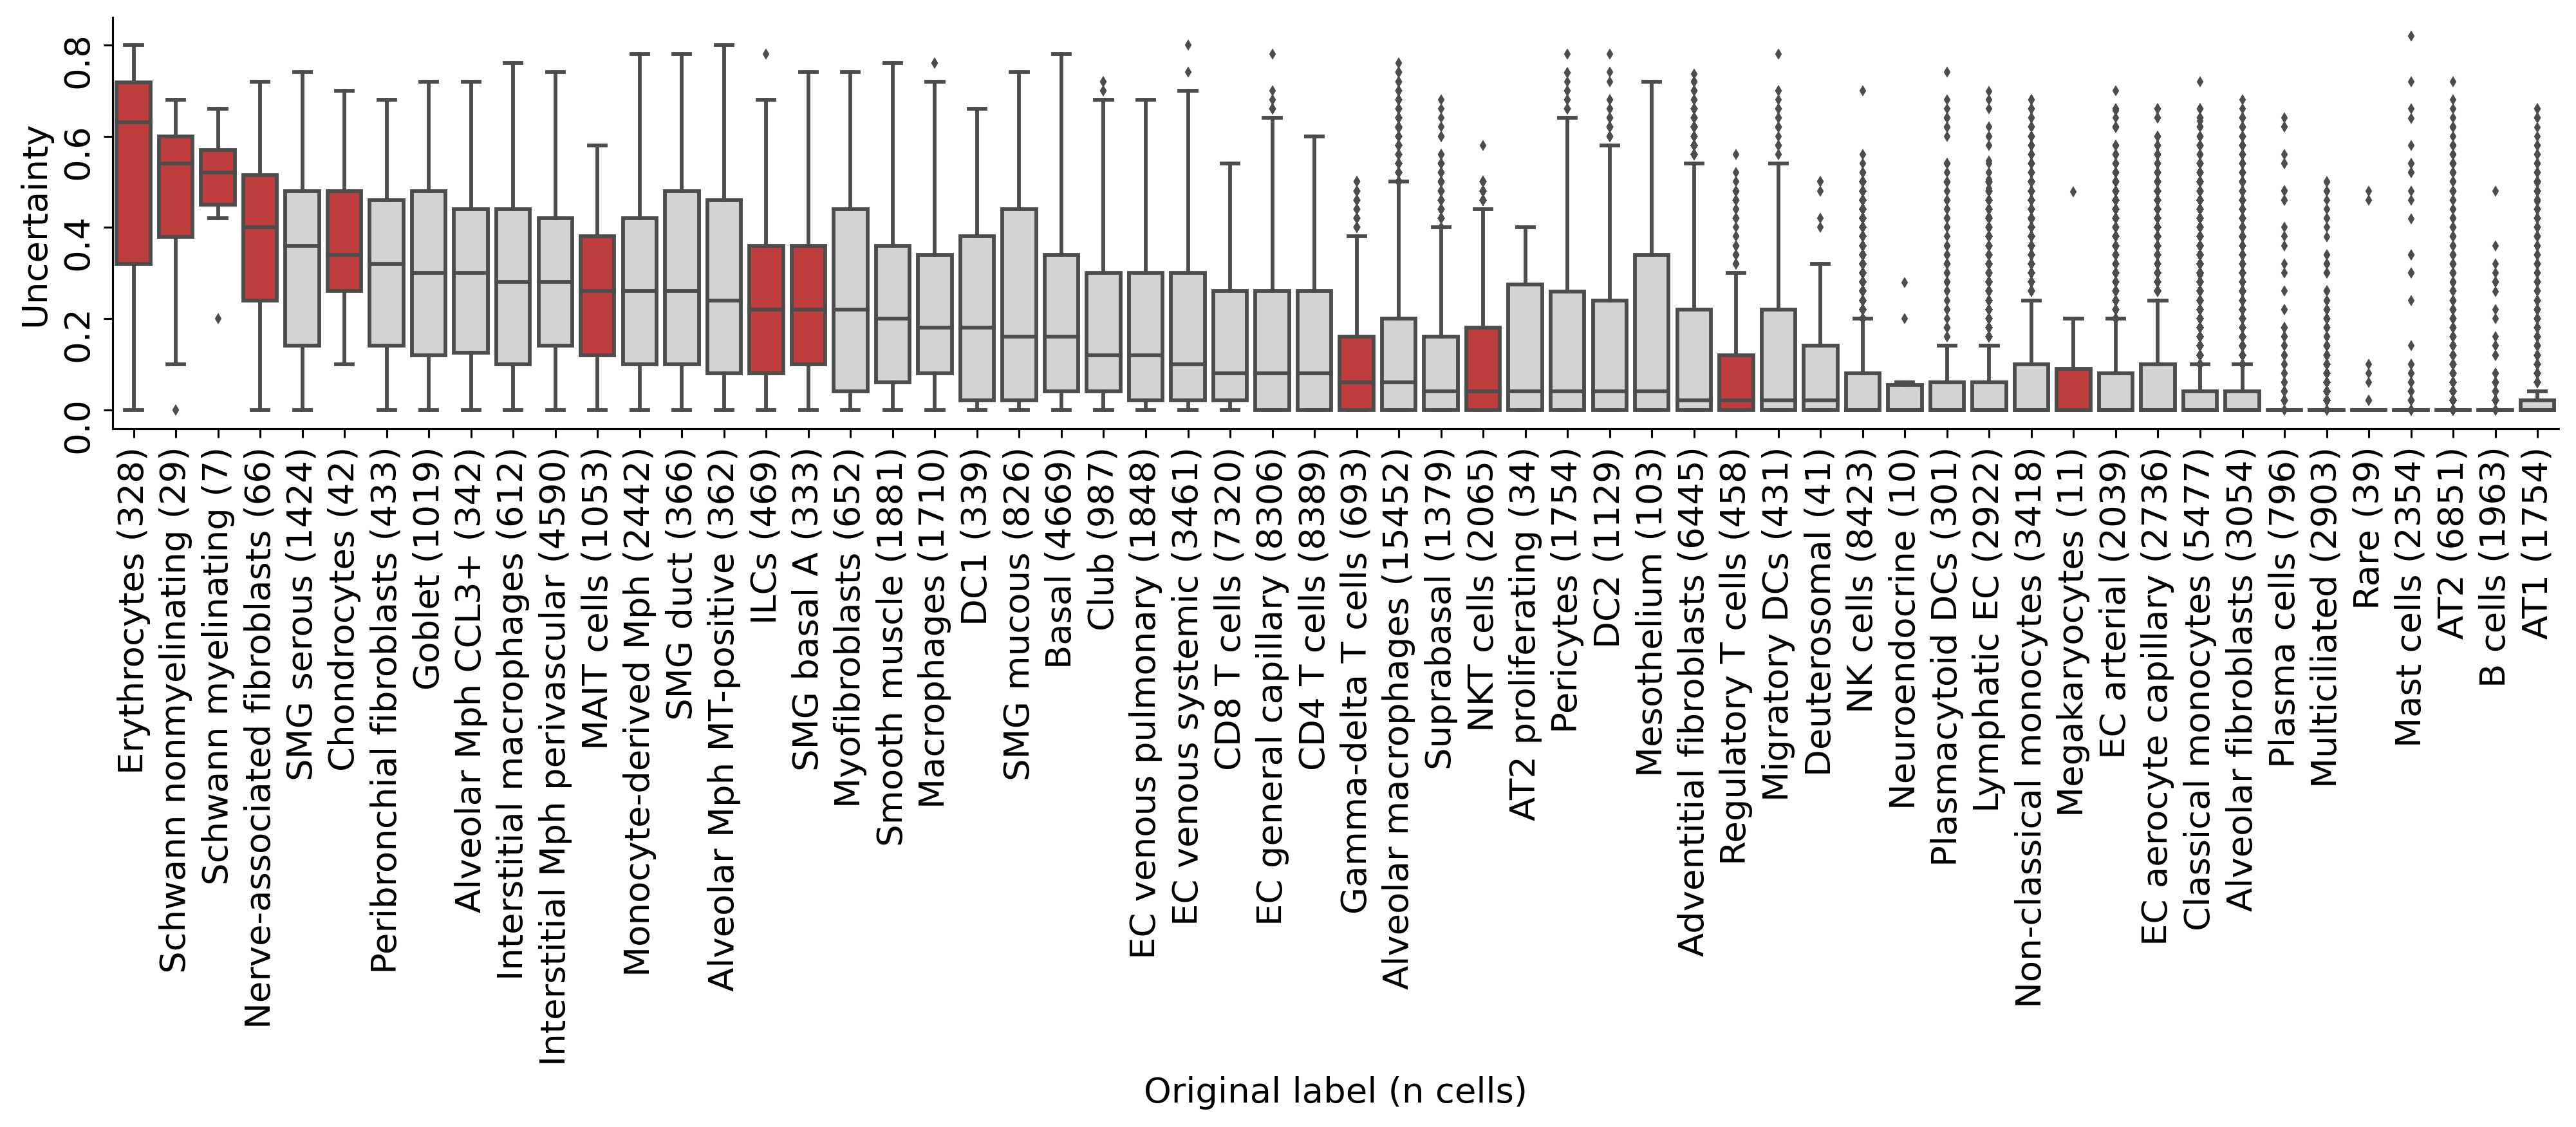

In [37]:
incl_celln_in_label = True
ct_order = (
    adata_meyer_obs.groupby("original_ann_for_label_tr_fig")
    .agg({"transf_ann_level_5_uncert": "median"})
    .sort_values(by="transf_ann_level_5_uncert", ascending=False)
    .index.tolist()
)
with plt.rc_context(
    {
        "figure.figsize": (0.3 * len(ct_order), 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = adata_meyer_obs.original_ann_for_label_tr_fig
    sns.boxplot(
        x=x,
        y=adata_meyer_obs.transf_ann_level_5_uncert,
        palette=custom_palette_unseen,
        ax=ax,
        fliersize=2,
        order=ct_order,
    )
    ax.tick_params(rotation=90)
    if incl_celln_in_label:
        total_n_per_ct = adata_meyer_obs.original_ann_for_label_tr_fig.value_counts()
        cts_no_underscore = [ct.replace("_", " ") for ct in ct_order]
        ax.set_xticklabels(
            [
                f"{ct_no_und} ({total_n_per_ct[ct]})"
                for ct_no_und, ct in zip(cts_no_underscore, ct_order)
            ],
        )
        ax.set_xlabel("Original label (n cells)")
    else:
        ax.set_xticklabels([ct.replace("_", " ") for ct in ct_order])
        ax.set_xlabel("Original label")
    ax.set_ylabel("Uncertainty")
    plt.grid(False)
    plt.show()
    FIGURES["ED12d_meyer_lab_tr_uncert_per_ct_boxplot"] = fig

uncertainty by *predicted* annotation:

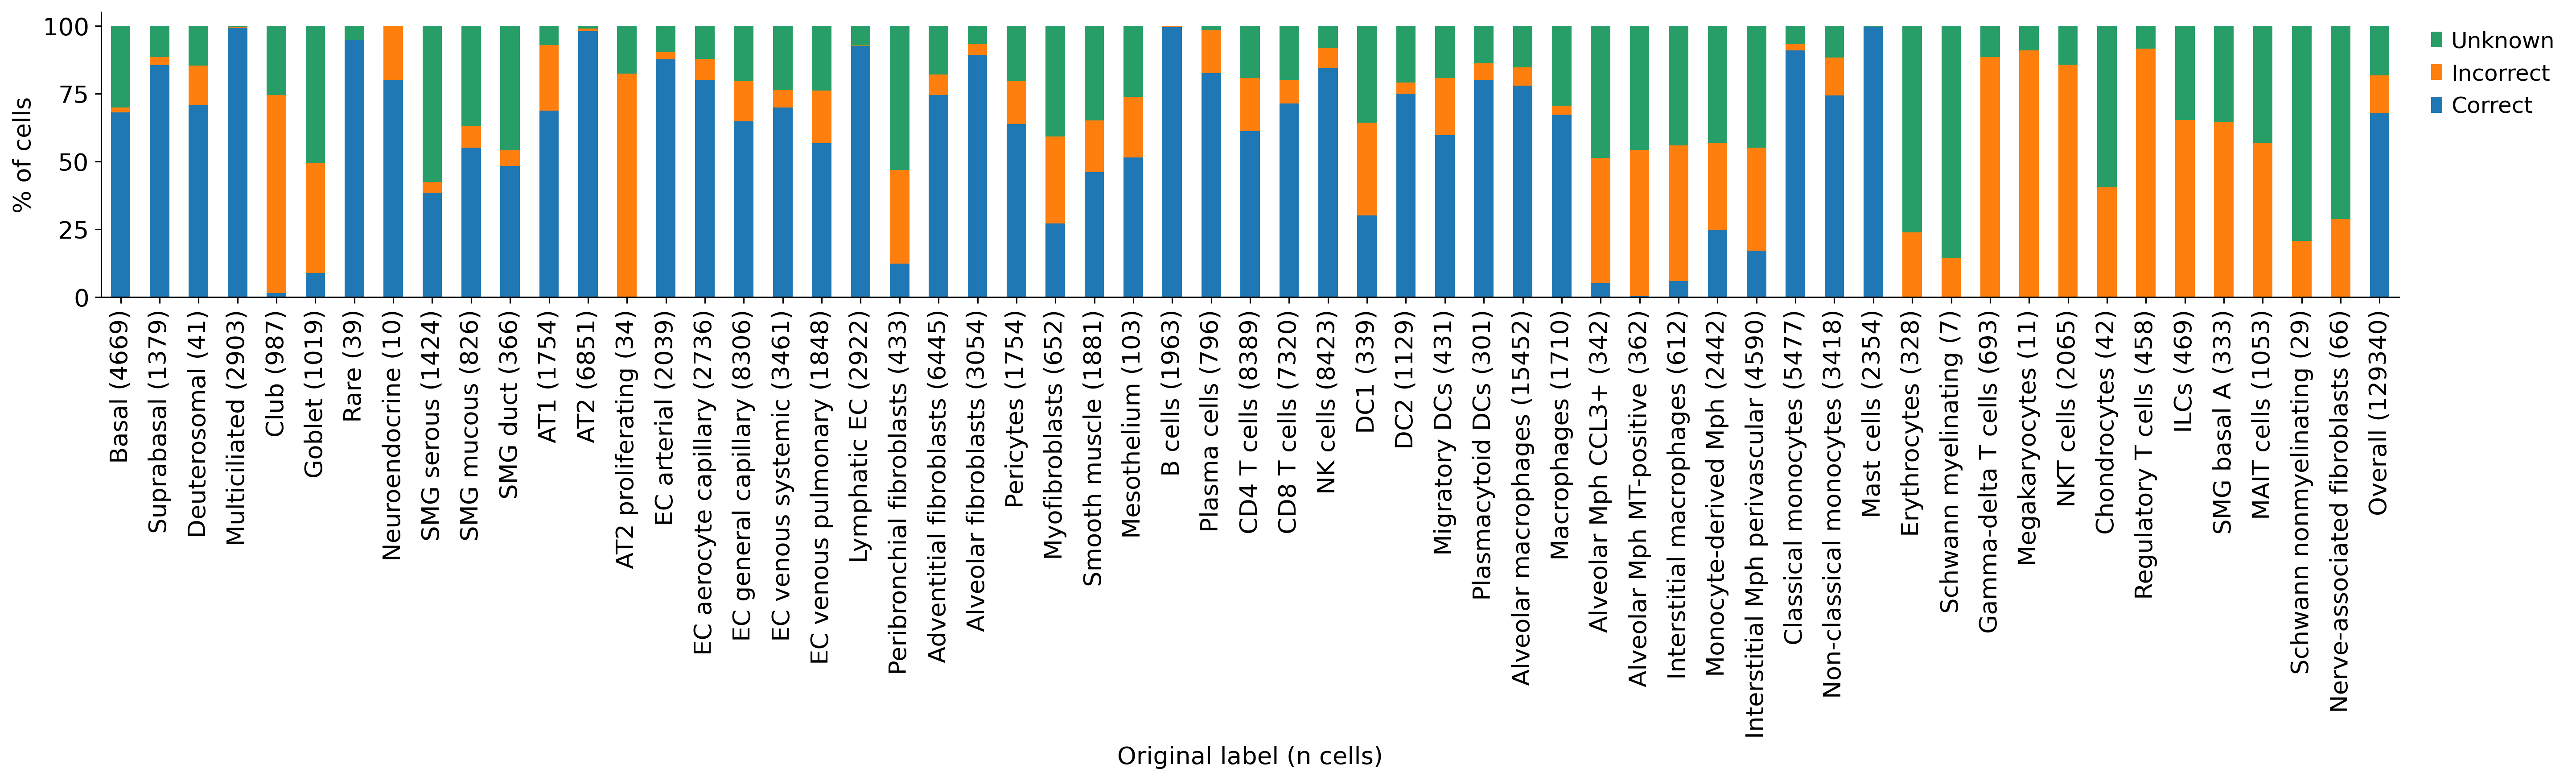

In [38]:
perc_correct = pd.crosstab(
    adata_meyer_obs.original_ann_for_label_tr_fig,
    adata_meyer_obs.label_tr_evaluation_thresholded,
).loc[ct_df_q, :]
total_n_per_ct = adata_meyer_obs.original_ann_for_label_tr_fig.value_counts()
perc_correct = perc_correct.div(perc_correct.sum(axis=1), axis="rows") * 100
# add a bar (=row) for the entire query dataset:
perc_correct.index = perc_correct.index.tolist()
total_n_per_ct.index = total_n_per_ct.index.tolist()
total_n_per_ct["Overall"] = adata_meyer_obs.shape[0]
perc_correct.loc["Overall", :] = (
    adata_meyer_obs.label_tr_evaluation_thresholded.value_counts()
    / total_n_per_ct["Overall"]
    * 100
)

incl_celln_in_label = True
# set celltype order:
# follow bio order, except that new/unseen cell types will come first:
ct_df_custom = [ct for ct in ct_df_q if ct not in new_cts] + new_cts + ["Overall"]
perc_correct = perc_correct.loc[ct_df_custom, :]
with plt.rc_context(
    {
        "figure.figsize": (0.4 * len(ct_df_custom), 3),
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    perc_correct.plot(kind="bar", stacked=True, ax=ax)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc=(1.01, 0.60), frameon=False)

    cts_no_underscore = [ct.replace("_", " ") for ct in ct_df_custom]
    if incl_celln_in_label:
        plt.xticks(
            ticks=range(len(ct_df_q) + 1),
            labels=[
                f"{ct_no_und} ({total_n_per_ct[ct]})"
                for ct_no_und, ct in zip(
                    cts_no_underscore + ["Overall"],
                    ct_df_custom,  # ct_df_q + ["Overall"]
                )
            ],
        )
        plt.xlabel("Original label (n cells)")
    else:
        plt.xticks(
            ticks=range(len(ct_df_custom)),
            labels=[f"{ct_no_und}" for ct_no_und in cts_no_underscore],
        )
        plt.xlabel("Original label")
    ax.set_ylabel("% of cells")
    plt.grid(False)
FIGURES[f"5b_meyer_label_transfer_eval_barplot_thr{unc_thresh}"] = fig

# Store figures:

In [39]:
for figname, fig in FIGURES.items():
    print("saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.png"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

saving ED12a_meyer_umap_ref_vs_q_ref
saving ED12b_meyer_umap_ref_vs_q_query
saving REVIEWER_meyer_umap_ref_vs_q_ref_splitby
saving REVIEWER_meyer_umap_ref_vs_q_query_splitby
saving ED12c_meyer_umap_core_anns
saving ED12c_meyer_umap_core_anns_labels_on_top
saving 5a_meyer_umap_uncert
saving ED5a_support_meyer_umap_query_orig_labels
saving ED12e_meyer_label_transfer_sankey_plot
saving ED12d_meyer_lab_tr_uncert_per_ct_boxplot
saving 5b_meyer_label_transfer_eval_barplot_thr0.3


## Store meyer label transfer info:

In [40]:
meyer_label_tr_results = adata_meyer_obs.loc[
    :,
    [
        "original_ann_level_5_no_prefix",
        "transf_ann_level_5_label_no_prefix",
        "original_ann_for_label_tr_fig",
        "label_tr_evaluation",
        "label_tr_evaluation_thresholded",
        "transf_ann_level_5_label_no_prefix_thresholded",
        "original_celltype_ann",
    ],
].rename(
    columns={
        "original_celltype_ann": "meyer_ann_unharmonized",
        "original_ann_level_5_no_prefix": "meyer_harmonized_ann_level_5",
        "transf_ann_level_5_label_no_prefix": "hlca_transferred_ann_level_5",
        "original_ann_for_label_tr_fig": "meyer_ann_for_figure",
        # "label_tr_evaluation",
        "label_tr_evaluation_thresholded": "label_tr_evaluation_including_unknown",
        "transf_ann_level_5_label_no_prefix_thresholded": "hlca_transfered_ann_level_5_including_unknown",
    }
)
meyer_label_tr_results = meyer_label_tr_results.loc[
    :, sorted(meyer_label_tr_results.columns)
]

In [41]:
meyer_label_tr_results.to_csv(path_meyer_label_transfer_results)